In [1]:
# Estymacja pierwszego modelu i zapis w HDFS

In [2]:
# Prerequisites

# !pip install pystan==2.19.1.1
# !pip install fbprophet
# !pip install plotly
# !pip install --upgrade pretty-confusion-matrix --user

In [3]:
from pyspark.sql import SparkSession
from fbprophet import Prophet

import numpy as np
import pandas as pd
from typing import List

from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

from sklearn import metrics
import seaborn as sns
from pretty_confusion_matrix import pp_matrix

from fbprophet.serialize import model_to_json, model_from_json

/opt/conda/anaconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Auxiliary functions

def load_parquet_from_HDFS(spark, fpath: List[str]):
    df = spark.read.parquet(fpath)

    return df


def estimate_prophet(df_train, date_col, y_col):
    regressors = list(set(df_train.columns) - set([date_col, y_col]))
    m = Prophet()

    for c in regressors:
        m.add_regressor(c)

    m.fit(df_train.toPandas())
    return m


def symmetric_mean_absolute_percentage_error(A, F):
    with np.errstate(divide='ignore', invalid='ignore'):
        tmp = 2 * np.abs(F-A) / (np.abs(A) + np.abs(F))
    tmp[np.isnan(tmp)] = 0
    return np.sum(tmp) / len(tmp) * 100


def assign_class(value, decision_boundaries):
    for _range, _class in decision_boundaries.items():
        # for every pair that you see in table
        if _range[0] <= value < _range[1]:
            return _class
        
        
def predict_class(model, df):
    pred = model.predict(df.toPandas())
    pred['y'] = df.toPandas().y

    decision_boundaries = {
        (-np.inf, -pred.y.quantile(0.9)): -1,
        (-pred.y.quantile(0.9), pred.y.quantile(0.9)): 0,
        (pred.y.quantile(0.9), np.inf): 1,
    }
    pred['class'] = pred.y.apply((lambda x: assign_class(x, decision_boundaries)))
    
    decision_boundaries = {
        (-np.inf, -pred.yhat.quantile(0.9)): -1,
        (-pred.yhat.quantile(0.9), pred.yhat.quantile(0.9)): 0,
        (pred.yhat.quantile(0.9), np.inf): 1,
    }

    pred['pred_class'] = pred.yhat.apply((lambda x: assign_class(x, decision_boundaries)))
    
    return pred[['ds', 'class', 'pred_class']]

In [5]:
# Parameters settings

train_fpath = "hdfs://cluster-bda2-m/user/root/modeling/in/df_day_train_scaled.parquet"

date_col = 'ds'
y_col = 'y'

In [6]:
spark = SparkSession \
    .builder \
    .appName("Time series data analysis with Spark") \
    .config("spark.redis.ssl", "true") \
    .getOrCreate()

In [7]:
# load data from HDFS
df_train = load_parquet_from_HDFS(spark, train_fpath)

In [8]:
# estimate regression model
model = estimate_prophet(df_train, date_col, y_col)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [9]:
with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(model))  # Save model

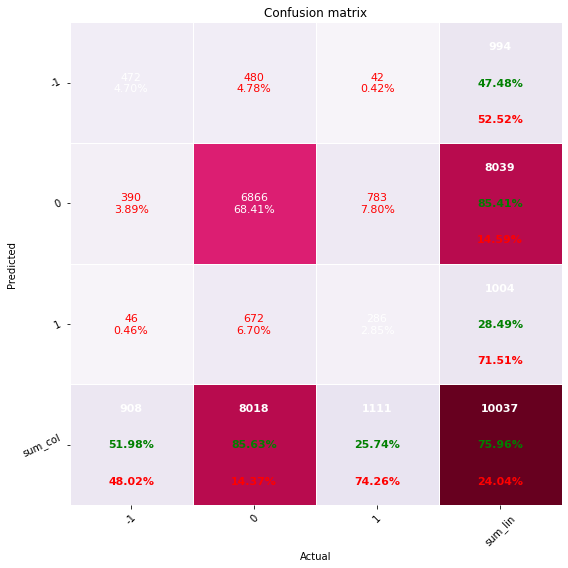

In [10]:
# Test

with open('serialized_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model (test)
    
print(m)

# transforming a regression problem into a classification one
pred = predict_class(m, df_train)

# evaluation on train set
array = metrics.confusion_matrix(pred['class'], pred['pred_class'])
df_cm = pd.DataFrame(array, index=[-1, 0, 1], columns=[-1, 0, 1])
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)